# 결정트리, 랜덤 포레스트, 부스팅
- 결정트리를 이용한 분류 모델 만들기
- 분류 모델의 손실함수
- 분류의 성능 평가
- 특성 중요도 (feature_importances_)
- 랜덤포레스트 이해
- 부스팅 알고리즘 이해
- 타이타닉 분류 문제

# import

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 맥에서 레티나 디스플레이 사용 설정
%config InlineBackend.figure_format = 'retina'

In [83]:
# 아래 명령은 한번만 실행하면 됨

# !pip install lightgbm

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report

# 데이터
## 타이타닉 생존 여부 예측

- Survival - 생존여부(타겟변수 y): 0 = No, 1 = Yes
- Pclass - 티켓 등급: 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex - 성별: male, female
- Age - 나이
- SibSp - 동승한 형제, 배우자 수
- Parch - 부모와 자녀의 수
- Ticket - 티켓 번호
- Fare - 승선 요금
- Cabin - 캐빈(객실) 번호
- Embarked - 승선한 항구: C = Cherbourg, Q = Queenstown, S = Southampton

## 데이터 전처리 종류

- 데이터 클리닝 - 결측치 처리, 틀린값 처리
- 스케일링 - 여러 변수 값의 범위를 동등한 조건으로 맞추는 것: 표준 스케일링, min-max 스케일링
- 이상치 처리 - 이상치 탐지 및 제거
- 데이터 변환 - 로그 변환, 카테고리 인코딩 등

In [85]:
## 데이터 전처리

# 데이터 다운로드
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/titanic_train.csv")

# 사용하지 않을 컬럼 4개 삭제
df = df[df.columns.difference(['PassengerId','Name','Ticket','Cabin'])]
# 나이 결측치를 평균 나이로 대체 (대체한 것을 즉시 반영했다)
df.Age.fillna(df.Age.mean(), inplace=True)
# Embarked (항구명) 결측치가 있는 두 샘플은 삭제
df = df[~df["Embarked"].isnull()]

# 선실등급, 성별, 항구명을 원핫 인코딩
df = pd.get_dummies(df, columns=['Pclass','Sex','Embarked'])
# 요금(Fare)은 로그를 취한 값을 사용
df["Fare"] = np.log(df.Fare +1)

# 트리 모델은 스케일링을 하지 않아도 된다!
# scaler = StandardScaler()
# df[['Age','Fare','SibSp','Parch']] = scaler.fit_transform(df[['Age','Fare','SibSp','Parch']])

# X와 y 얻기
X = df[df.columns.difference(['Survived'])]
y = df.Survived

print(X.shape)
X[:5]

(889, 12)


,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp
0,22.0,0,0,1,2.110213,0,0,0,1,0,1,1
1,38.0,1,0,0,4.280593,0,1,0,0,1,0,1
2,26.0,0,0,1,2.188856,0,0,0,1,1,0,0
3,35.0,0,0,1,3.990834,0,1,0,0,1,0,1
4,35.0,0,0,1,2.202765,0,0,0,1,0,1,0


# 결정트리 모델

- 동작 개요

<img src = "https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.17.21.png?raw=1" width="250"  align="left">




## 트리를 만드는 과정


<img src = "https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2010.53.59.png?raw=1" width="600"  align="left">
<img src = "https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2010.54.34.png?raw=1" width="600"  align="left">




## 트리 모델 과대적합

- 트리 모델은 depth를 크게 하면 항상 과대적합이 된다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2010.55.04.png?raw=1" width="600"  align="left">




## 트리모델의 손실함수

- 각 depth에서 결정 트리를 선택하는 기준은 새로 나누어질 그룹에 가능하면 같은 종류의 샘플이 많이 나누어 모이는 지를 측정한다
- 즉, 순도(purity)가 가능한 높아지도록 나눈다
- 순도가 높아지는 것을 측정하는데 엔트로피를 사용한다
 - 순도가 높아질수록 엔트로피는 줄어든다

### 엔트로피 

- 확률 p인 사건의 가치:  $log$(${1}\over{p}$) 
- 엔트로피=확률x기대치: $Entropy(H)$ = $p$ $log$(${1}\over{p}$)

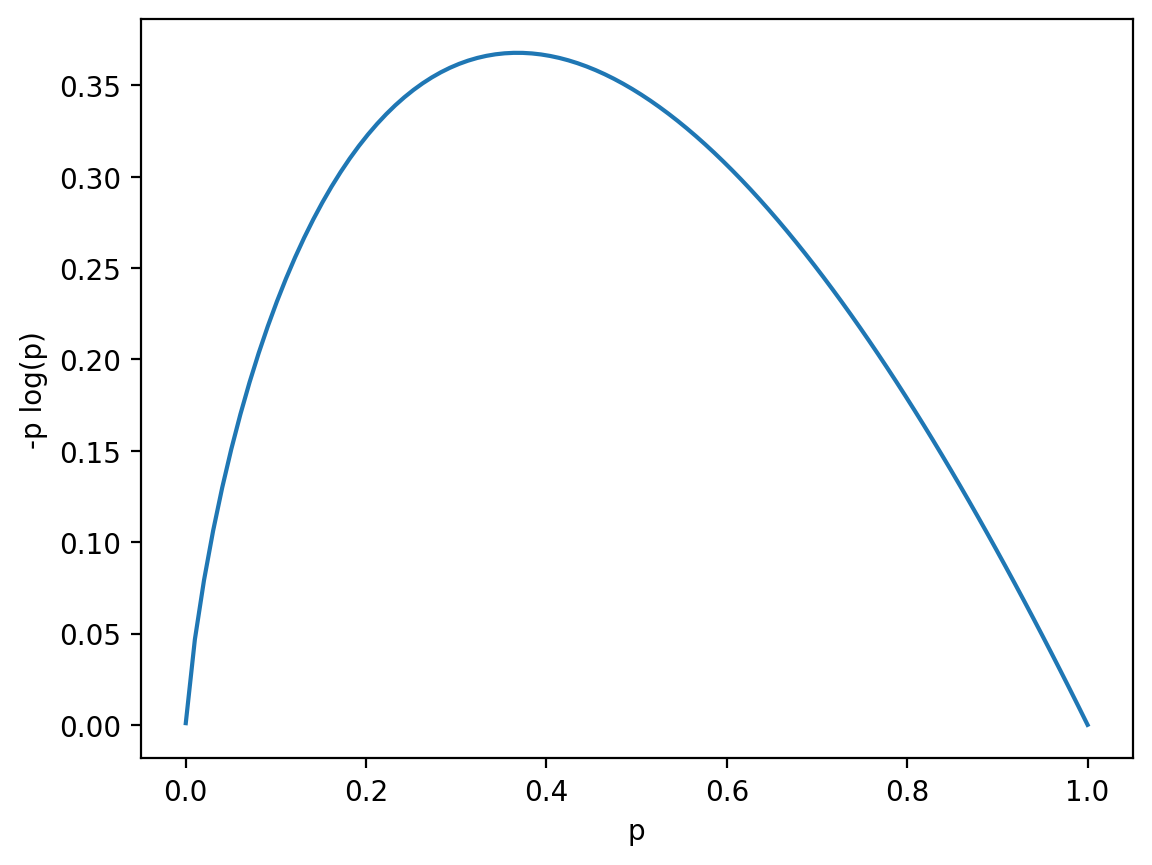

In [86]:
## 확률 p와 엔트로피 보기

xs = np.linspace(0.0001, 1, 100)
plt.plot(xs, -xs*np.log(xs))
plt.xlabel("p")
plt.ylabel("-p log(p)")
plt.show()

### 크로스 엔트로피 

- 분류할 여러 클래스들에 대해서 각각의 엔트로피를 더한 값을 크로스 엔트로피라고 한다
- 분류가 잘 수행될수록 (즉, 분류된 하위 그룹의 p가 1 또는 0으로 수렴할수록) 크로스 엔트로피의 합은 점차 줄어들며 이를 분류의 손실함수로 사용한다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%208.29.58.png?raw=1" align='left'  width=150>

### gini 계수

- 크로스 엔트로피와 유사한 값을 얻으면서 계산량을 줄이기 위해서 지니 계수를 주로 사용한다

$1 - \sum {p_{i}}^2$

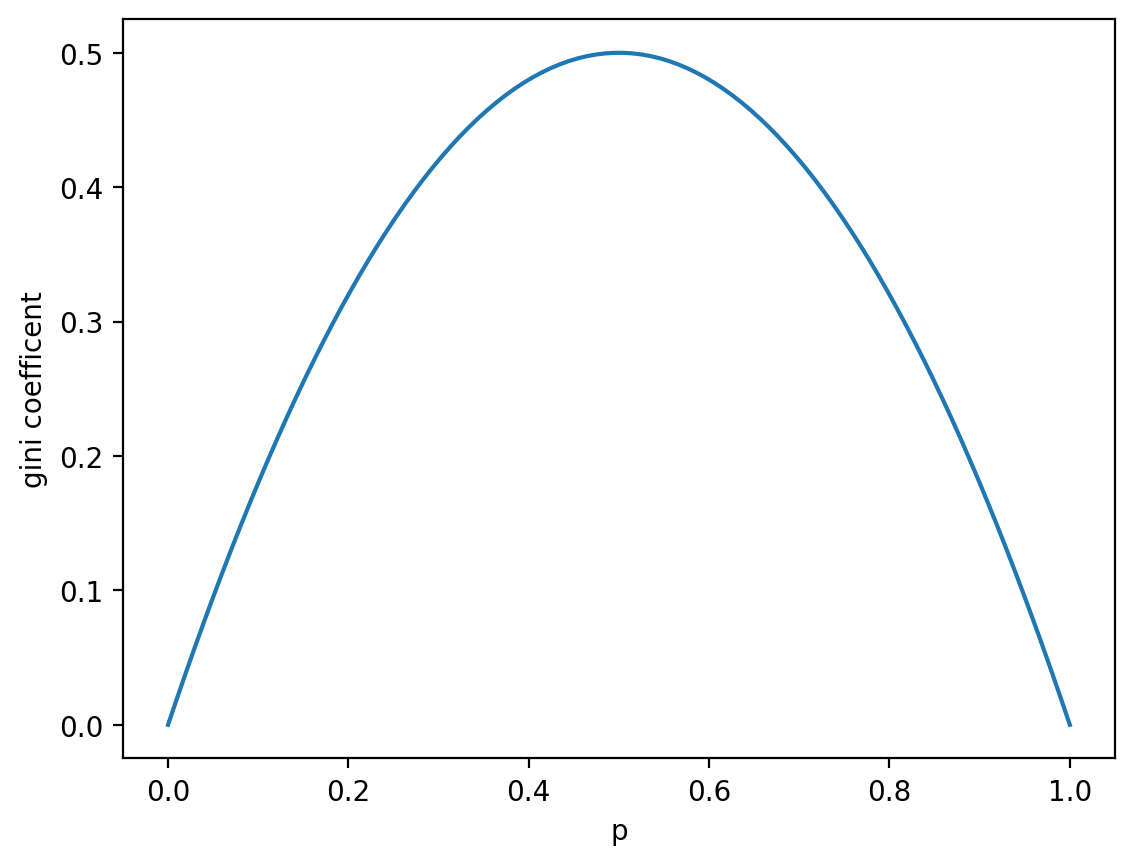

In [87]:
## 이진 분류에 대해서, 확률 p와 (1-p)의 지니 계수 보기

xs = np.linspace(0, 1, 100)
plt.plot(xs, 1-(xs**2 + (1-xs)**2))
plt.xlabel("p")
plt.ylabel("gini coefficent")
plt.show()

In [88]:
# 샘플을 a와 b개로 나누었을 때 지니 계수를 구하는 함수
def gini_index(a,b):
    p = a/(a+b)
    q = 1 - p
    return np.round((1-p**2 - q**2),3)

In [89]:
# 타이타닉 훈련 데이터 666 샘플 y 값의 분포

y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [90]:
# 분류하기 전에 (root trre) 타이타닉 데이터의 지니계수
gini_index(409,257)

0.474

# 결정 트리를 이용한 이진 분류

## 데이터 나누기

In [106]:
## 데이터 나누기

X_train, X_test, y_train, y_test = train_test_split(X, y)

## 최적의 트리 깊이 (max_depth)

- 결정 트리 모델은 depth 가 깊어지면 과대적합이 되어 성능이 떨어진다

In [92]:
## 결정 트리를 이용한 이진 분류

for depth in range(1,10):
    dtc = DecisionTreeClassifier(max_depth=depth) 
    dtc.fit(X_train, y_train) 
    print(depth, dtc.score(X_test, y_test).round(3)) 

1 0.794
2 0.762
3 0.812
4 0.812
5 0.807
6 0.798
7 0.726
8 0.753
9 0.749


In [93]:
## 최적의 트리 깊이 max_depth=3

dtc = DecisionTreeClassifier(max_depth=3) 
dtc.fit(X_train, y_train) 
print(dtc.score(X_test, y_test).round(3)) 

0.812


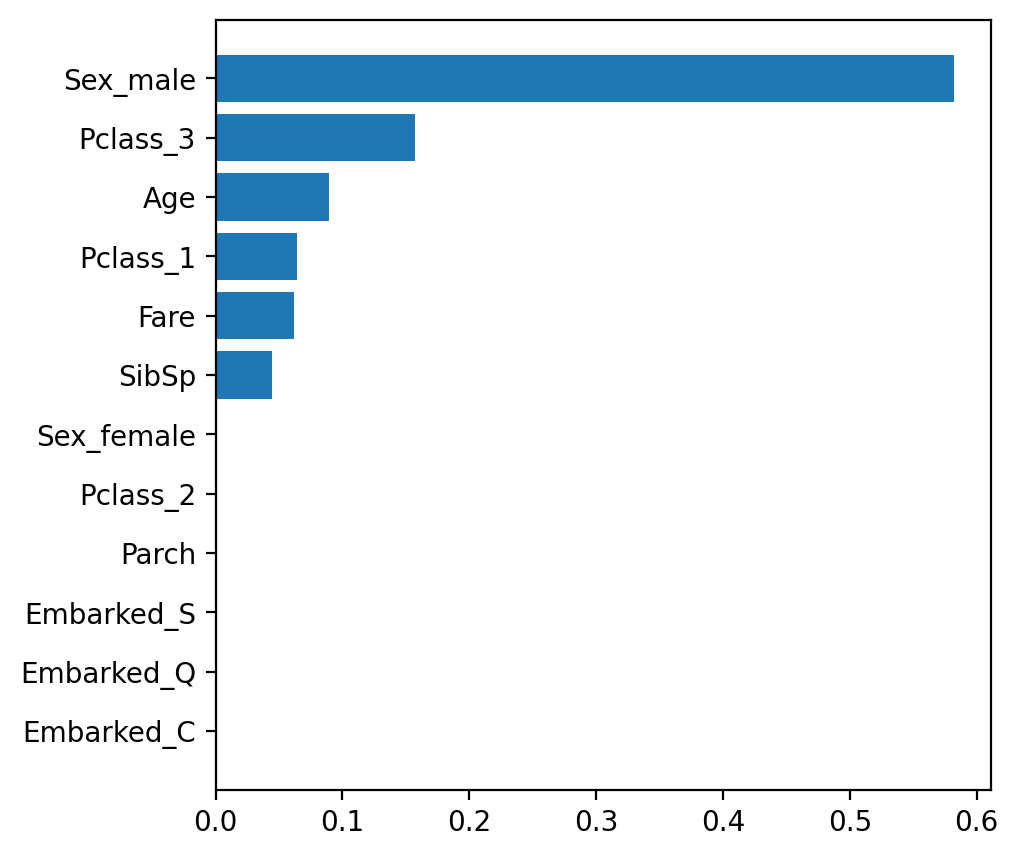

In [94]:
## 특성 가중치(중요도) 보는 함수 정의

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,5))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)
    
plot_feature_weight(X.columns, dtc.feature_importances_)

## 혼돈 매트릭스와 분류 평가 보기

In [95]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

y_pred = dtc.predict(X_test)
show_clf_result(y_test, y_pred)

[[120  20]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       140
           1       0.75      0.73      0.74        83

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



## 결정 트리 보기

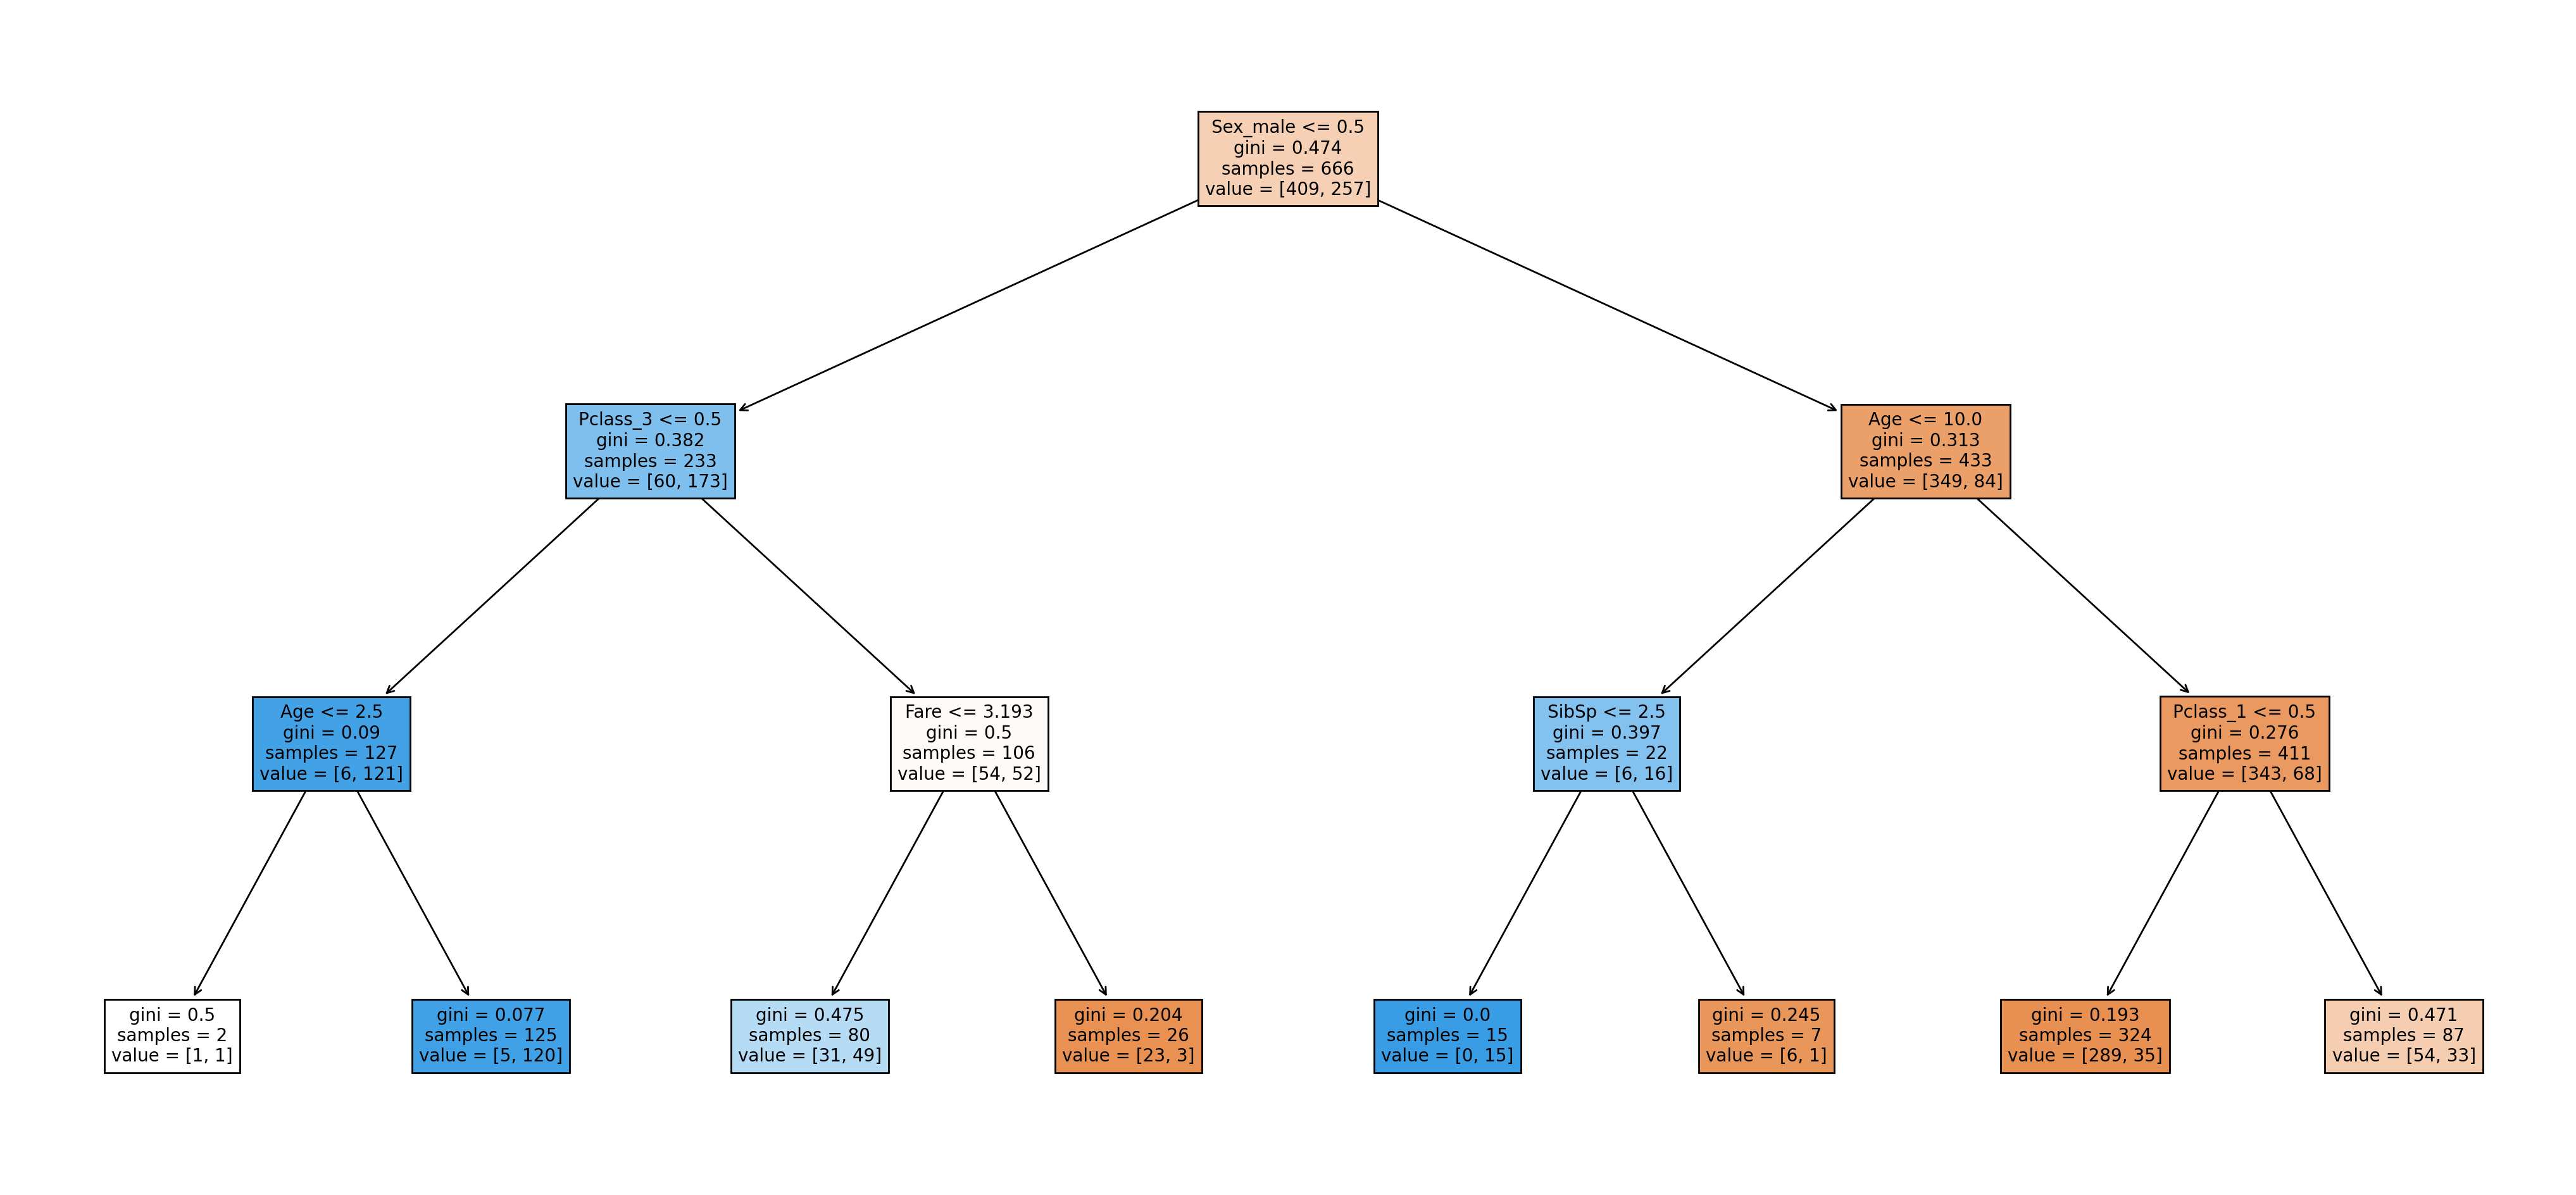

In [96]:
## 결정 트리 보기 (2단까지만 보기)

from sklearn import tree
import matplotlib
plt.figure(figsize=(26,12))

tree.plot_tree(dtc, fontsize=10,
              feature_names=list(X.columns),
              filled=True,
              impurity=True,
              max_depth=3)
plt.show()

# 랜덤 포레스트

- 결정 트리의 성능을 개선한 방법
- 간단한 구조의 결정 트리(weak learner)를 수십~수백개를 만들고 각 결정 트리의 동작 결과의 평균치를 구하는 방법
- 각 약한 결정 트리를 만들 때 훈련 데이터의 일부만 사용하거나 특성의 일부를 무작위로 선택하여 만든다 
- 이러한 기법을 앙상블(ensemble) 기법이라고 하며, 하나의 디테일한 모델만 만드는 것보다 항상 더 좋은 성능을 보인다
- 앙상블을 구할때 hard voting 또는 soft voting을 선택할 수 있다

- 랜덤 포레스트 개념

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.13.52.png?raw=1" align='left'  width=400>

- soft voting과 hard voting

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.52.18.png?raw=1" align='left'  width=400>

In [97]:
## 랜덤 포레스트를 이용한 이진 분류

# 최적의 트리 깊이(max_depth)를 실험으로 찾는다
# 약한 트리 모델 갯수, n_estimators 디폴트 값은 100이다

for depth in range(1,10):
    rfc = RandomForestClassifier(n_estimators=50, max_depth=depth)
    rfc.fit(X_train, y_train) 
    print(depth,rfc.score(X_test, y_test).round(4))

1 0.7892
2 0.7937
3 0.8341
4 0.8206
5 0.8206
6 0.8027
7 0.7892
8 0.7937
9 0.7937


In [98]:
## 최적의 모델 (max_depth=5)

rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X_train, y_train) 
print(rfc.score(X_test, y_test).round(4))

# 혼돈 매트릭스와 분류 평가 보기
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

0.8251
[[124  16]
 [ 23  60]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       140
           1       0.79      0.72      0.75        83

    accuracy                           0.83       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.83      0.82       223



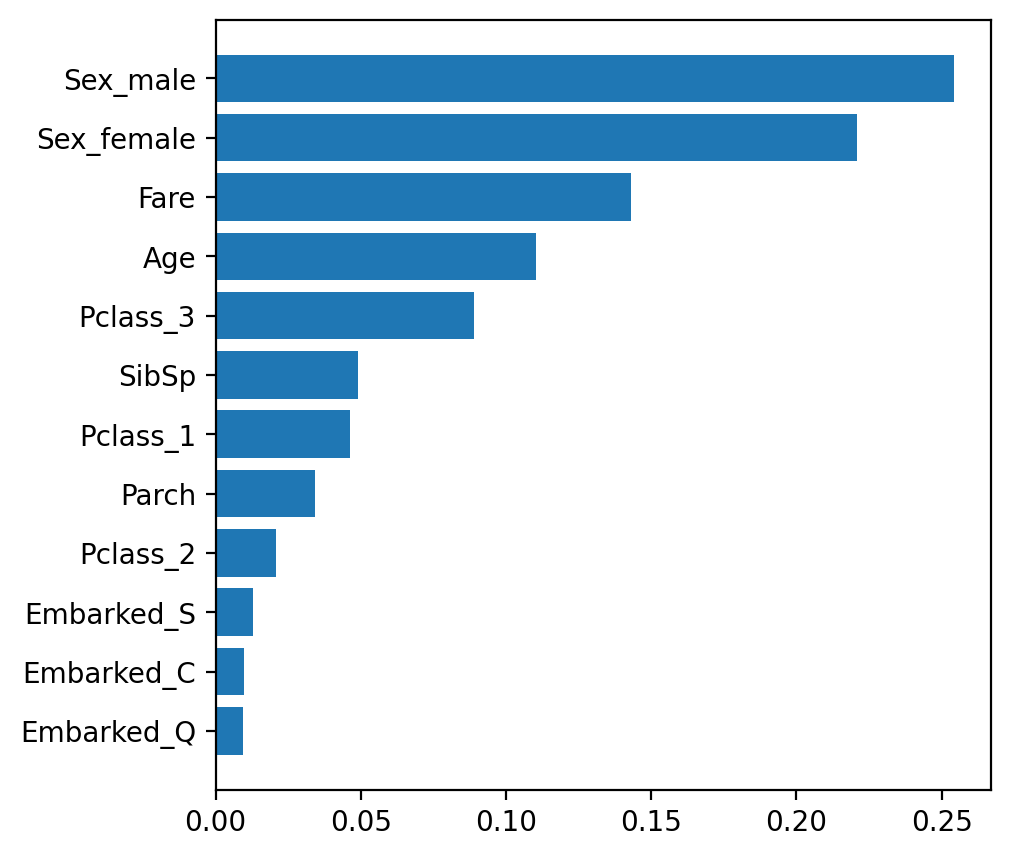

In [99]:
## 특성 중요도 (feature_importances_ 보기)

plot_feature_weight(X.columns, rfc.feature_importances_)

# 부스팅 (LightGBM)

- 랜덤 포레스트가 다수의  weak 트리모델을 병행하여 실행하고 결과를 취한하는 방식이라면, 부스팅 모델은 다수의 트리 모델을 순차적으로 실행하는 방식이다
- 순차적으로 실행하면서 앞 단의 모델 결과를 반영하여 점차 성능을 개선하는 방향으로 하습시킨다(boosting)
- lightgbm을 설치해야 한다

In [100]:
lgbm_c = LGBMClassifier(num_leaves=16)
lgbm_c.fit(X_train, y_train)
lgbm_c.score(X_test, y_test).round(4)

[LightGBM] [Info] Number of positive: 257, number of negative: 409
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385886 -> initscore=-0.464639
[LightGBM] [Info] Start training from score -0.464639


0.8117

In [101]:
## 혼돈 매트릭스와 분류 평가 보기

y_pred = lgbm_c.predict(X_test)
show_clf_result(y_test, y_pred)

[[119  21]
 [ 21  62]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       140
           1       0.75      0.75      0.75        83

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



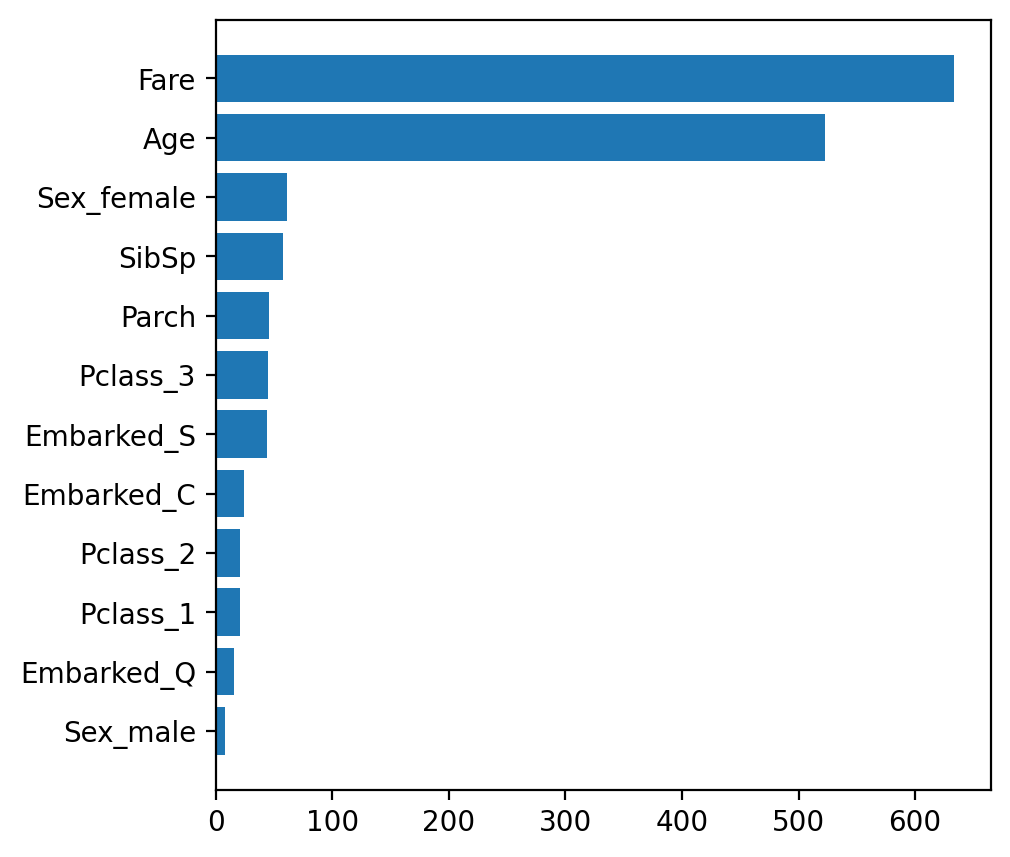

In [102]:
## 특성 중요도 (feature_importances_ 보기)

plot_feature_weight(X.columns, lgbm_c.feature_importances_)

## 예측 결과 보기
- X_test, 실제값 y_test, 예측값 y_pred, 분류점수(score) 보기

In [103]:
df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_pred'] = y_pred
proba =  lgbm_c.predict_proba(X_test)[:,1].round(3)
df_test['proba'] = proba
df_test[:10]

,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp,y_test,y_pred,proba
35,42.000000,0,0,1,3.970292,0,1,0,0,0,1,1,0,0,0.420
563,29.699118,0,0,1,2.202765,0,0,0,1,0,1,0,0,0,0.096
496,54.000000,1,0,0,4.372818,0,1,0,0,1,0,1,1,1,0.996
371,18.000000,0,0,1,2.014343,0,0,0,1,0,1,1,0,0,0.036
306,29.699118,1,0,0,4.717456,0,1,0,0,1,0,0,1,1,0.988
166,29.699118,0,0,1,4.025352,1,1,0,0,1,0,0,1,1,0.993
225,22.000000,0,0,1,2.336987,0,0,0,1,0,1,0,0,0,0.024
284,29.699118,0,0,1,3.295837,0,1,0,0,0,1,0,0,0,0.282
734,23.000000,0,0,1,2.639057,0,0,1,0,0,1,0,0,0,0.013
329,16.000000,1,0,0,4.077185,1,1,0,0,1,0,0,1,1,0.998


# 정밀도와 재현률 선택
- 클래스 분류 확률을 이용하여 정밀도가 높거나, 재현률이 높은 예측 모델을 만들 수 있다 

## 디폴트 모델
- proba > 0.5를 기준으로 동작하는 모델
- 머신러닝 모델이 기본으로 만들어주는 모델
- 정밀도와 재현률이 모두 적절히 좋은, 즉 f-1 점수가 좋은 모델을 찾아준다

In [105]:
y_pred_default = proba > 0.5
show_clf_result(y_test, y_pred_default)

[[119  21]
 [ 21  62]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       140
           1       0.75      0.75      0.75        83

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



# (실습) 정밀도 선택
- 정밀도가 0.9 이상이 되는 모델을 찾으시오
- 이때의 확률 경계치 (1로 분류하는 확률 기준치)는 얼마인가? 
- 이때의 재현률은 얼마인가?

# (실습) 재현률 선택
- 재현률이 0.9 이상이 되는 모델을 찾으시오
- 이때의 확률 경계치 (1로 분류하는 확률 기준치)는 얼마인가? 
- 이때의 정밀도는 얼마인가?